# Генетический алгоритм


In [1]:
from sympy.combinatorics.graycode import random_bitstring, gray_to_bin
from random import randint
import pandas as pd
import matplotlib.pyplot as plt
from prettytable import PrettyTable
import warnings

warnings.filterwarnings("ignore")

In [2]:
class Tochka:
    def __init__(self, number_gen=300, divider=20, counter_generation=4, m=32):
        self.number_gen = number_gen # Количество генотипов
        self.divider = divider # Количество групп
        self.counter_generation = counter_generation # Количество поколений
        self.m = m

        self.df = pd.DataFrame(columns=['bkgx1', 'bkgx2', 'l1', 'l2', 'x1', 'x2', 'f1', 'f2'])
        self.dftime = pd.DataFrame(columns=['bkgx1', 'bkgx2', 'l1', 'l2', 'x1', 'x2', 'f1', 'f2', 'b', 'fitness'])


    def generate_initial_population(self):
        for i in range(self.number_gen):
            bkgx1 = random_bitstring(self.m)
            bkgx2 = random_bitstring(self.m)
            l1 = int(gray_to_bin(bkgx1), 2)
            l2 = int(gray_to_bin(bkgx2), 2)
            x1 = l1 * (79 / (2 ** self.m - 1))
            x2 = l2 * (79 / (2 ** self.m - 1))
            f1 = 0.2 * (x1 - 70) ** 2 + 0.8 * (x2 - 20) ** 2
            f2 = 0.2 * (x1 - 10) ** 2 + 0.8 * (x2 - 70) ** 2
            row = {'bkgx1': bkgx1, 'bkgx2': bkgx2, 'l1': l1, 'l2': l2, 'x1': x1, 'x2': x2, 'f1': f1, 'f2': f2}
            self.df = pd.concat([self.df, pd.DataFrame([row])], ignore_index=True)
        # Вывод исходной популяции в численном виде
        self.display_initial_population()


    def display_initial_population(self):
        print("Исходная популяция:")

        # Таблица исходных битовых строк
        table_bkg = PrettyTable()
        table_bkg.field_names = ["bkgx1", "bkgx2"]
        for _, row in self.df[['bkgx1', 'bkgx2']].iterrows():
            table_bkg.add_row(row)
        print(table_bkg)

        # Таблица перевода в код Грея и значения признаков
        table_gray = PrettyTable()
        table_gray.field_names = ["l1", "l2", "x1", "x2", "f1", "f2"]
        for _, row in self.df[['l1', 'l2', 'x1', 'x2', "f1", "f2"]].iterrows():
            table_gray.add_row(row)
        print("\nПеревод кода Грея\t\t Значения признаков \t\t\t Значения f1 и f2:")
        print(table_gray)


    # Оценка приспособленности каждой особи
    def calculate_fitness_function(self, dataframe):
        bi_counter = []
        values_function = []
        for index1, row1 in dataframe[['f1', 'f2']].iterrows():
            count = 0
            for index2, row2 in dataframe[['f1', 'f2']].iterrows():
                if row1[0] > row2[0] and row1[1] > row2[1]:
                    count += 1
            bi_counter.append(count)
            values_function.append((self.number_gen - 1) / (self.number_gen - 1 + count))
        return bi_counter, values_function

    def update_fitness(self):
        bi, f = self.calculate_fitness_function(self.df)
        self.df['b'] = bi
        self.df['fitness'] = f

        table_fitness = PrettyTable()
        table_fitness.field_names = ["x1", "x2", "f1", "f2", "b", "fitness"]
        for _, row in self.df[['x1', 'x2', "f1", "f2", 'b', 'fitness']].iterrows():
            table_fitness.add_row(row)
        print("\nЗначения признаков \t\t\t Значения f1 и f2 \t\t\t Оценка:")
        print(table_fitness)


    def plot_initial_population(self):
        fig, ax = plt.subplots()
        plt.ion()
        line, = ax.plot(self.df['x1'].tolist(), self.df['x2'].tolist(), 'o', color='g')
        for j1 in range(self.number_gen):
            plt.text(self.df['x1'][j1], self.df['x2'][j1], j1, fontsize=8)
        plt.xlabel('x1')
        plt.ylabel('x2')
        plt.title('Множество D')
        plt.plot([79, 79], [0, 79], color='blue')
        plt.plot([0, 79], [79, 79], color='blue')
        plt.plot([0, 79], [0, 0], color='blue')
        plt.plot([0, 0], [0, 79], color='blue')
        plt.draw()
        plt.pause(0.001)


    def tournament_selection(self, k=2):
        best_parents = pd.DataFrame(columns=self.df.columns)
        count = 0
        while count < self.number_gen:
            # Случайный выбор k особей
            tournament_players = self.df.sample(n=k)
            # Выбор лучшей особи из турнира
            best_parent = tournament_players.nlargest(1, 'fitness')
            best_parents = pd.concat([best_parents, best_parent], ignore_index=True)
            count += 1
        return best_parents

    def display_best_parents(self, best_parents):
        print("Лучшие родители:")
        print(best_parents[['bkgx1', 'bkgx2', 'x1', 'x2', 'fitness']])

    def new_generation(self, best_parents):
        df_childs = pd.DataFrame({
            'bkgx1': [], 'bkgx2': [], 'l1': [], 'l2': [], 'x1': [], 'x2': [], 'f1': [], 'f2': [],
        })
        counter = 0
        while counter != self.number_gen:
            random = randint(0, self.number_gen - 1 - counter)
            parent1 = best_parents.iloc[random]
            best_parents.drop(labels=random, axis=0, inplace=True)
            best_parents.reset_index(drop=True, inplace=True)
            counter += 1
            random = randint(0, self.number_gen - 1 - counter)
            parent2 = best_parents.iloc[random]
            best_parents.drop(labels=random, axis=0, inplace=True)
            best_parents.reset_index(drop=True, inplace=True)
            counter += 1

            left = randint(1, self.number_gen - 1)
            right = randint(1, self.number_gen - 1)
            sectors1 = [parent1['bkgx1'][:left], parent1['bkgx1'][left:], parent1['bkgx2'][:right], parent1['bkgx2'][right:]]
            sectors2 = [parent2['bkgx1'][:left], parent2['bkgx1'][left:], parent2['bkgx2'][:right], parent2['bkgx2'][right:]]
            for i in range(1, 4, 2):
                temp = sectors1[i]
                sectors1[i] = sectors2[i]
                sectors2[i] = temp

            child1_bkgx1 = sectors1[0] + sectors1[1]
            child1_bkgx2 = sectors1[2] + sectors1[3]
            child2_bkgx1 = sectors2[0] + sectors2[1]
            child2_bkgx2 = sectors2[2] + sectors2[3]

            l1 = int(gray_to_bin(child1_bkgx1), 2)
            l2 = int(gray_to_bin(child1_bkgx2), 2)
            x1 = l1 * (79 / (2 ** self.m - 1))
            x2 = l2 * (79 / (2 ** self.m - 1))
            f1 = 0.2 * (x1 - 70) ** 2 + 0.8 * (x2 - 20) ** 2
            f2 = 0.2 * (x1 - 10) ** 2 + 0.8 * (x2 - 70) ** 2
            row1 = {'bkgx1': child1_bkgx1, 'bkgx2': child1_bkgx2, 'l1': l1, 'l2': l2, 'x1': x1, 'x2': x2, 'f1': f1, 'f2': f2}
            df_childs = pd.concat([df_childs, pd.DataFrame([row1])], ignore_index=True)

            l1 = int(gray_to_bin(child2_bkgx1), 2)
            l2 = int(gray_to_bin(child2_bkgx2), 2)
            x1 = l1 * (79 / (2 ** self.m - 1 ))
            x2 = l2 * (79 / (2 ** self.m - 1))
            f1 = 0.2 * (x1 - 70) ** 2 + 0.8 * (x2 - 20) ** 2
            f2 = 0.2 * (x1 - 10) ** 2 + 0.8 * (x2 - 70) ** 2
            row2 = {'bkgx1': child2_bkgx1, 'bkgx2': child2_bkgx2, 'l1': l1, 'l2': l2, 'x1': x1, 'x2': x2, 'f1': f1, 'f2': f2}
            df_childs = pd.concat([df_childs, pd.DataFrame([row2])], ignore_index=True)

        b, fitness_value = self.calculate_fitness_function(df_childs)
        df_childs.insert(8, 'b', b)
        df_childs.insert(9, 'fitness', fitness_value)
        return df_childs


    def mutation(self, bkgx):
        random_index = randint(0, len(bkgx) - 1)
        if bkgx[random_index] == '0':
            bkgx = bkgx[:random_index] + '1' + bkgx[random_index + 1:]
        else:
            bkgx = bkgx[:random_index] + '0' + bkgx[random_index + 1:]
        return bkgx

    def counter_elite_points(self, dataframe):
        return sum(dataframe['fitness'] == 1)

    def counter_elite_points_indices(self, dataframe):
        return dataframe.index[dataframe['fitness'] == 1].tolist()

    def evolve(self):
        plt.ion()
        fig, ax = plt.subplots()
        line, = ax.plot(self.df['f1'].tolist(), self.df['f2'].tolist(), 'o', color='black')
        for j2 in range(self.number_gen):
            plt.text(self.df['f1'][j2], self.df['f2'][j2], j2, fontsize=8, color='green')
        plt.xlabel('f1')
        plt.ylabel('f2')
        plt.title('Все родители')
        line.set_xdata(self.df['f1'].tolist())
        line.set_ydata(self.df['f2'].tolist())
        plt.draw()
        plt.gcf().canvas.flush_events()
        plt.pause(4)

        ostanovka = self.number_gen * 0.7
        for i in range(self.counter_generation):
            df_parents = self.tournament_selection()
            df = self.new_generation(df_parents)

            count_elite = self.counter_elite_points(df)
            stime = self.counter_elite_points_indices(df)
            print(f'Поколение {i+1}, элитных точек: {count_elite} {stime}')
            print(df)
            print()

            fig, ax = plt.subplots()
            plt.ion()
            line, = ax.plot(df['x1'].tolist(), df['x2'].tolist(), 'o', color='green')
            for j3 in range(self.number_gen):
                plt.text(df['x1'][j3], df['x2'][j3], j3, fontsize=8)
            plt.xlabel('x1')
            plt.ylabel('x2')
            plt.title(f'Множество допустимых альтернативных решений D, Поколение: {i+1}')
            line.set_xdata(df['x1'].tolist())
            line.set_ydata(df['x2'].tolist())
            plt.plot([79, 79], [0, 79], color='blue')
            plt.plot([0, 79], [79, 79], color='blue')
            plt.plot([0, 79], [0, 0], color='blue')
            plt.plot([0, 0], [0, 79], color='blue')
            plt.draw()
            plt.pause(0.001)

            fig, ax = plt.subplots()
            line, = ax.plot(df['f1'].tolist(), df['f2'].tolist(), 'o', color='green')
            for j in range(self.number_gen):
                plt.text(df['f1'][j], df['f2'][j], j, fontsize=8)
            plt.title(f'Поколение {i+1}')
            plt.draw()
            plt.gcf().canvas.flush_events()
            plt.pause(2)

            if count_elite >= ostanovka:
                break

        self.dftime = self.dftime.drop_duplicates()
        print("Общий массив")
        print(self.dftime.to_string(index=False))
        print()

        self.dftime = self.dftime[self.dftime.fitness == 1]
        self.dftime = self.dftime.sort_values(by='fitness', ascending=False)
        print("Сортированный массив")
        print(self.dftime.to_string(index=False))
        print()
        plt.ioff()
        plt.show()

## Шаг 1. Инициализация начальной популяции.

In [3]:
tochka = Tochka()
tochka.generate_initial_population()

Исходная популяция:
+----------------------------------+----------------------------------+
|              bkgx1               |              bkgx2               |
+----------------------------------+----------------------------------+
| 00101000111111101010001010101100 | 00000100000101001110000010010110 |
| 10100011001100101101011101111010 | 01111111110101101001110011011010 |
| 10000011011010000011100110111011 | 00011111101100011011101010111100 |
| 10111001000011000000011100001001 | 11000110000000101110100001011100 |
| 00001001000010101111001011101011 | 11000001010101001011000100001101 |
| 00001111001111111100001101100011 | 00110010110010100010000011011100 |
| 11110000110111100001110001101001 | 00010011011110001011111101000010 |
| 01110010101011101011010101001000 | 00001010001111001001000001000011 |
| 01000000101111100100111000110000 | 01000110001001101001101110100001 |
| 00011010011111001111001110111000 | 10010110011101011111111101000000 |
| 10110101001100010001110110010011 | 1010010

Случайным образом генерируются bkgx1 и bkgx2. Они представляют собой двоичные строки длиной m.
Используя функцию gray_to_bin, битовые строки преобразуются в двоичные строки. Например, gray_to_bin(bkgx1) преобразует битовую строку bkgx1 в обычное двоичное представление.
Далее с помощью функции int(gray_to_bin(bkgx1), 2) двоичное число преобразуется в целое. Полученное значение масштабируется относительно диапазона от 0 до 79

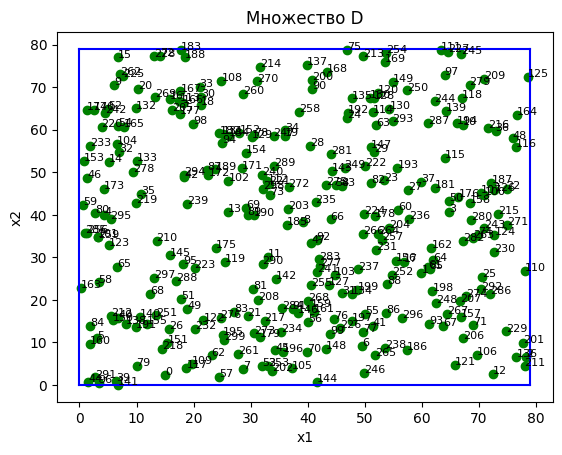

In [4]:
tochka.plot_initial_population()

## Шаг 2. Оценка приспособленности каждой тестовой точк–особи (TTO)

Для каждой пары особей в популяции сравниваются значения f1 и f2.
Если текущая особь доминирует над другой особью по обоим значениям функций, увеличивается счетчик count.

**bi** для каждой особи равен значению этого счетчика.

**fitness** для каждой особи рассчитывается на основе ее bi и общего числа особей в популяции.


In [5]:
tochka.update_fitness()


Значения признаков 			 Значения f1 и f2 			 Оценка:
+---------------------+---------------------+--------------------+---------------------+-------+--------------------+
|          x1         |          x2         |         f1         |          f2         |   b   |      fitness       |
+---------------------+---------------------+--------------------+---------------------+-------+--------------------+
|  15.018917189682583 |  2.4389194469989555 | 851.2971335501895  |  3656.6375903426556 | 154.0 | 0.6600441501103753 |
|  59.90985681487011  |  26.352108327521037 | 52.64162206293432  |  2022.3095194181342 |  0.0  |        1.0         |
|  78.28659743729202  |  6.520459554977822  | 159.09194790473788 |  4156.333522001521  |  45.0 | 0.8691860465116279 |
|  64.79501596530784  |  40.738366112517745 | 349.4822349737396  |  1285.4933291397083 |  5.0  | 0.9835526315789473 |
|  4.335546778360277  |  39.99286681017672  | 1182.135862010955  |  726.7596398774639  |  24.0 | 0.9256965944272446 |
|  

## Шаг 3. Выбор из популяции массива родителей, для скрещивания с учетом их приспособленности

Турнирная селекция предполагает случайный выбор нескольких особей из популяции и выбор наилучшей из них в качестве родителя. Этот процесс повторяется несколько раз, чтобы сформировать пары родителей для скрещивания.
Этот метод случайным образом выбирает k особей из популяции, проводит турнир и выбирает наилучшую особь, повторяя этот процесс для каждой особи в популяции. В результате он возвращает DataFrame с лучшими родителями.

In [6]:
best_parents = tochka.tournament_selection()
tochka.display_best_parents(best_parents)

Лучшие родители:
                                bkgx1                             bkgx2  \
0    11010111111010000010111100111011  00101000100101111001001010011101   
1    00011111101101100010000000100000  11101100001000011000100001100000   
2    10010111010111110000110011010000  01001100011110110011010001000001   
3    10100011001100101101011101111010  01111111110101101001110011011010   
4    00100011101111111000011010100011  11001101001001101011010100101110   
..                                ...                               ...   
295  00011111101101100010000000100000  11101100001000011000100001100000   
296  10111100101101011100110000000111  11001000110001111110111101011011   
297  10010001001000010111111011010001  00011101100110001111011000011110   
298  01110111000101001110101101110011  00011100111101010111101001001000   
299  11111101111111000100001001111000  01001010100111010010001101010010   

            x1         x2   fitness  
0    47.735849  15.088683  0.931464  
1     

## Шаг 4. Формирование массива генотипов потомков на основе воздействия на генотипы родителей генетических операторов.

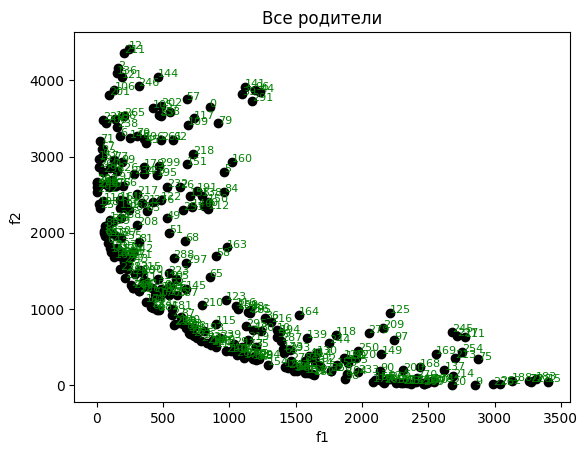

Поколение 1, элитных точек: 101 [1, 13, 21, 27, 33, 36, 37, 38, 42, 45, 49, 55, 56, 62, 66, 69, 71, 74, 76, 80, 81, 82, 89, 91, 94, 95, 97, 99, 118, 128, 131, 133, 136, 138, 146, 148, 153, 157, 158, 159, 161, 163, 167, 172, 173, 174, 175, 176, 177, 179, 180, 181, 183, 185, 186, 189, 193, 194, 197, 199, 200, 201, 203, 207, 212, 213, 214, 216, 217, 220, 223, 227, 228, 229, 230, 231, 234, 239, 240, 243, 244, 245, 248, 249, 250, 252, 255, 256, 257, 258, 263, 264, 268, 278, 279, 280, 287, 288, 293, 294, 296]
                                bkgx1                             bkgx2  \
0    01010101010001101010100010110011  10001011000101001000000100011110   
1    00100100101000100101110100000111  10110100110101111001100011011000   
2    10000011011010000011100110111011  00011111101100011011101010111100   
3    11011100001111111001000000011011  10000000010011111010111011001011   
4    01001111000000101111010000100100  01000101011111110110110111011110   
..                                ...    

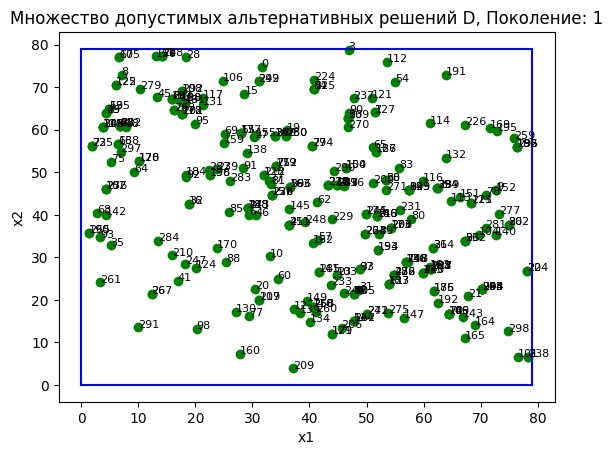

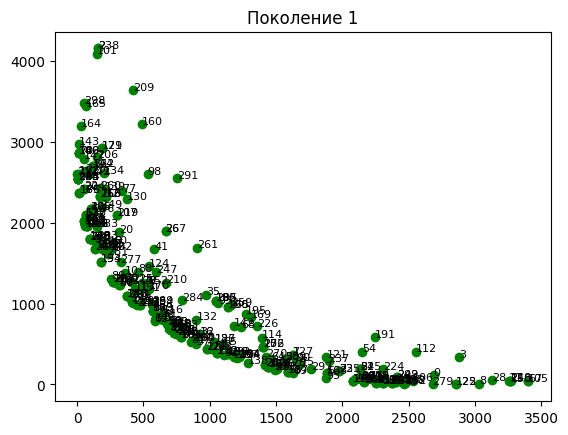

Поколение 2, элитных точек: 98 [0, 1, 5, 7, 8, 13, 19, 20, 21, 23, 24, 26, 31, 37, 38, 39, 43, 44, 46, 47, 50, 51, 56, 60, 63, 65, 74, 81, 85, 89, 91, 93, 94, 106, 115, 117, 118, 122, 126, 128, 143, 145, 151, 152, 153, 154, 162, 163, 165, 166, 167, 168, 169, 172, 173, 177, 179, 184, 188, 190, 193, 195, 196, 197, 198, 199, 200, 202, 204, 205, 207, 208, 210, 214, 218, 224, 228, 231, 233, 237, 243, 245, 253, 254, 258, 262, 263, 266, 268, 274, 279, 285, 287, 289, 293, 297, 298, 299]
                                bkgx1                             bkgx2  \
0    10100101111000000110001101111011  01110100011010111110001010111000   
1    11110001101101010111001101110100  01001011101101000110011101010010   
2    01010011110011011010010101101100  01101101100100101000100011110100   
3    11111000000101101110100100001100  01001100110111101001101001001101   
4    11000001011010111010011100100100  01100000001000101000101000111000   
..                                ...                             

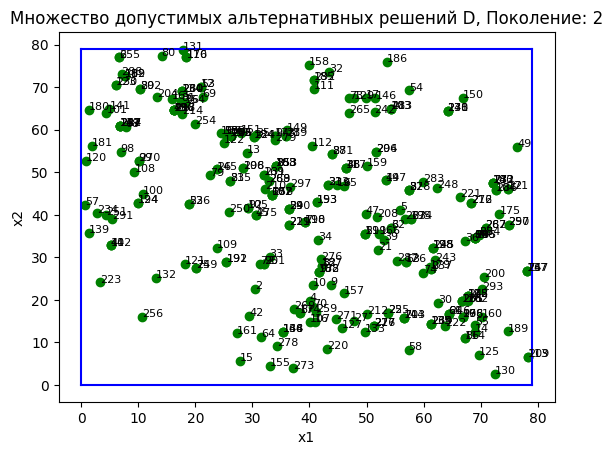

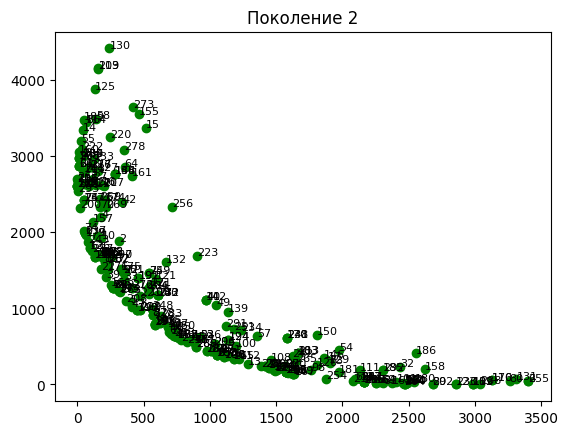

Поколение 3, элитных точек: 99 [5, 6, 11, 15, 19, 20, 24, 26, 27, 30, 32, 35, 37, 39, 42, 47, 49, 53, 54, 55, 61, 63, 67, 68, 69, 76, 83, 87, 91, 94, 95, 96, 99, 103, 106, 107, 116, 119, 120, 123, 125, 126, 127, 128, 131, 136, 137, 138, 143, 144, 147, 149, 152, 158, 160, 162, 165, 166, 170, 180, 187, 188, 190, 191, 192, 193, 197, 198, 199, 200, 211, 212, 222, 224, 226, 227, 232, 236, 237, 238, 243, 245, 249, 251, 262, 269, 272, 273, 278, 279, 284, 285, 286, 287, 290, 292, 294, 298, 299]
                                bkgx1                             bkgx2  \
0    10111101110001010001011101001110  10100100111010000111100110000110   
1    00001111111101111011100111101100  01001000011111011010101101110000   
2    01001111000000101111010000100100  01000101011111110110110111011110   
3    11101001011101100011101111100101  01111010001011111000011011100001   
4    11110111011101011110100100101000  11101110100011111110101111001000   
..                                ...                     

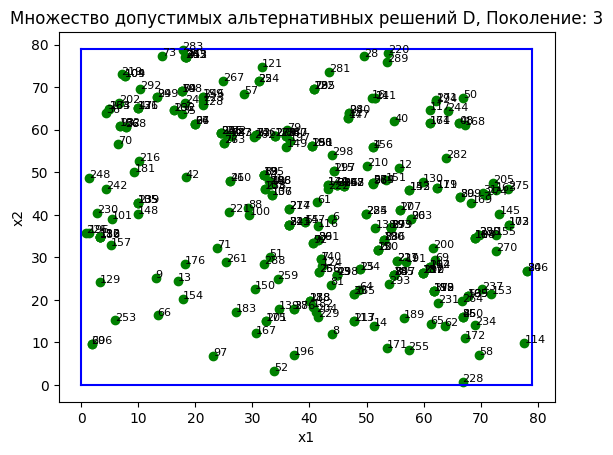

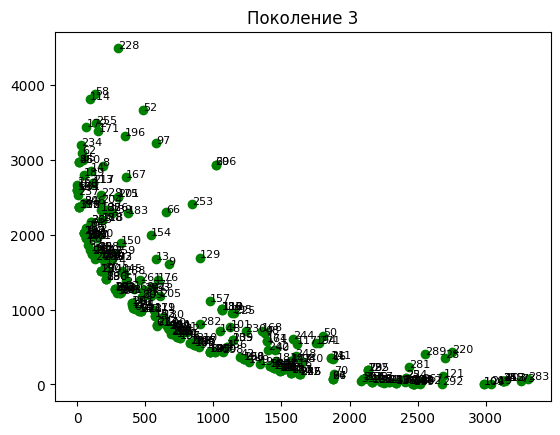

Поколение 4, элитных точек: 106 [5, 9, 15, 16, 18, 20, 27, 28, 30, 32, 35, 48, 51, 54, 56, 57, 58, 62, 64, 66, 68, 70, 76, 77, 78, 79, 82, 87, 88, 90, 92, 95, 97, 104, 108, 114, 118, 119, 120, 132, 134, 135, 144, 149, 150, 151, 157, 161, 166, 170, 171, 175, 176, 177, 179, 180, 181, 182, 183, 184, 190, 191, 195, 197, 201, 203, 204, 205, 207, 208, 215, 217, 220, 221, 223, 227, 229, 231, 233, 234, 238, 239, 240, 251, 254, 257, 258, 259, 261, 263, 264, 270, 273, 276, 278, 279, 282, 283, 285, 289, 290, 291, 292, 293, 295, 296]
                                bkgx1                             bkgx2  \
0    11000011100010011110000010010000  11101101000110100110111010011101   
1    00011000111001101101100001001010  11111101001110000011111101101000   
2    11010111110011000001011110010001  10110111010100001110100001001111   
3    11000110000100110001100101100100  10010001111101101101010100010001   
4    00101010010010000011011011111100  01010011111111100101010110010000   
..                    

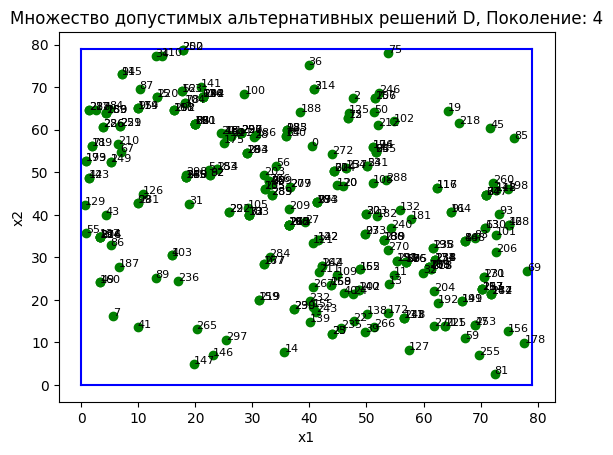

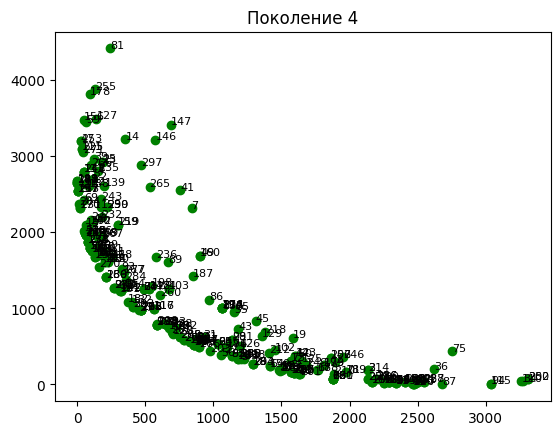

Общий массив
Empty DataFrame
Columns: [bkgx1, bkgx2, l1, l2, x1, x2, f1, f2, b, fitness]
Index: []

Сортированный массив
Empty DataFrame
Columns: [bkgx1, bkgx2, l1, l2, x1, x2, f1, f2, b, fitness]
Index: []



In [7]:
tochka.evolve()

### Получено множеством субоптимальных решений